# Create ML Models with BigQuery ML: Challenge Lab


This notebook is written to document my solutions to the Google Cloud [challenge lab](https://google.qwiklabs.com/focuses/14294?parent=catalog) for the **[Create ML Models with BigQuery ML](https://google.qwiklabs.com/quests/146)** quest. This challenge lab tests skills in developing and using machine learning models using BigQuery.

You can earn a skill badge after completing the quest and the challenge lab.

[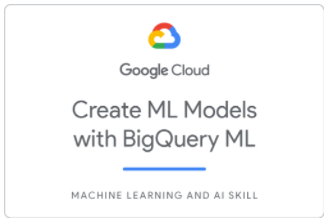](https://google.qwiklabs.com/public_profiles/c0a951c2-747f-4e4a-9520-3a67696131fb)





## Topics tested

- Create a new BigQuery dataset which will store the BigQuery ML models.
- Create forecasting (linear regression) models in BigQuery ML.
- Evaluate the performance of machine learning models.
- Make predictions of trip duration using BigQuery ML models.

## Challenge scenario

You have started a new role as a junior member of the Data Science department Jooli Inc. Your team is working on a number of machine learning initiatives related to urban mobility services. You are expected to help with the development and assessment of data sets and machine learning models to help provide insights based on real work data sets.

## Your challenge

One of the projects you are working on needs to provide analysis based on real world data that will help in the selection of new bicycle models for public bike share systems. Your role in this project is to develop and evaluate machine learning models that can predict average trip durations for bike schemes using the public data from Austin's public bike share scheme to train and evaluate your models.

Two of the senior data scientists in your team have different theories on what factors are important in determining the duration of a bike share trip and you have been asked to prioritise these to start. The first data scientist maintains that the key factors are the start station, the location of the start station, the day of the week and the hour the trip started. While the second data scientist argues that this is an over complication and the key factors are simply start station, subscriber type, and the hour the trip started.

You have been asked to develop a machine learning model based on each of these input features. Given the fact that stay-at-home orders were in place for Austin during parts of 2020 as a result of COVID-19 you will be working on data from previous years. You have been instructed to train your models on data from 2018 and then evaluate them against data from 2019 on the basis of Mean Absolute Error and the square root of Mean Squared Error.

You can access the public data for the Austin bike share scheme in your project by opening [this link to the Austin bike share dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=austin_bikeshare&page=dataset) in the browser tab for your lab.

As a final step you must create and run a query that uses the model that includes subscriber type as a feature, to predict the average trip duration for all trips from the busiest bike sharing station in 2019 (based on the number of trips per station in 2019) where the subscriber type is 'Single Trip'.

## Preview of the Austin bike share dataset

Before starting the challenge, let's preview the Austin bike share dataset first.

The 2 tables are `bikeshare_stations` and `bikeshare_trips`.

### bikeshare_stations (schema)

![station](station_schema.PNG)

### bikeshare_stations (preview)

![station](station_preview.PNG)

### bikeshare_trips (schema)

![trips](trips_schema.PNG)

### bikeshare_trips (preview)

![trips](trips_preview.PNG)




## Task 1: Create a dataset to store your machine learning models

Create a new dataset in which you can store your machine learning models.

*Solution for Task 1:* 

*A dataset named **Austin_bike** is created.*

![T1](create_dataset.PNG)

## Task 2: Create a forecasting BigQuery machine learning model

Create the first machine learning model to predict the trip duration for bike trips. 

The features of this model must incorporate:
- the starting station name
- the hour the trip started
- the weekday of the trip
- the location of the start station

You must use 2018 data only to train this model.

In [ ]:
# Solution for Task 2:

CREATE OR REPLACE MODEL Austin_bike.duration_model_1
OPTIONS
    (model_type='linear_reg', labels=['duration_minutes']) AS
SELECT
    duration_minutes,
    start_station_name,
    EXTRACT(HOUR FROM start_time) AS start_hour,
    EXTRACT(DAYOFWEEK FROM start_time) AS day,
    location
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
INNER JOIN
    `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
ON
    trips.start_station_name = stations.name
WHERE
    EXTRACT(YEAR FROM start_time) = 2018
    AND duration_minutes > 0


## Task 3: Create the second machine learning model

Create the second machine learning model to predict the trip duration for bike trips. 

The features of this model must incorporate:
- the starting station name
- the bike share subscriber type
- the start time for the trip

You must also use 2018 data only to train this model.

In [ ]:
# Solution for Task 3:

CREATE OR REPLACE MODEL Austin_bike.duration_model_2
OPTIONS
    (model_type='linear_reg', labels=['duration_minutes']) AS
SELECT
    duration_minutes,
    start_station_name,
    subscriber_type,
    EXTRACT(HOUR FROM start_time) AS start_hour    
FROM 
    `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
WHERE EXTRACT(YEAR FROM start_time) = 2018
    AND duration_minutes > 0


## Task 4: Evaluate the two machine learning models

Evaluate each of the machine learning models against 2019 data only using separate queries. 

Your queries must report both the **Mean Absolute Error** and the **Root Mean Square Error**.

In [ ]:
# Solution for Task 4 (first model):

SELECT
    SQRT(mean_squared_error) AS rmse,
    mean_absolute_error AS mae
FROM
    ML.EVALUATE(MODEL `Austin_bike.duration_model_1`, (
    SELECT
        duration_minutes,
        start_station_name,
        EXTRACT(HOUR FROM start_time) AS start_hour,
        EXTRACT(DAYOFWEEK FROM start_time) AS day,
        location
    FROM
        `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
    INNER JOIN
        `bigquery-public-data.austin_bikeshare.bikeshare_stations` AS stations
    ON 
        trips.start_station_name = stations.name
    WHERE EXTRACT(YEAR FROM start_time) = 2019
        AND duration_minutes > 0
    ))


![rmse1](rmse_model1.PNG)

In [ ]:
# Solution for Task 4 (second model):

SELECT
    SQRT(mean_squared_error) AS rmse,
    mean_absolute_error AS mae
FROM
    ML.EVALUATE(MODEL `Austin_bike.duration_model_2`, (
    SELECT
        duration_minutes,
        start_station_name,
        subscriber_type,
        EXTRACT(HOUR FROM start_time) AS start_hour  
    FROM
        `bigquery-public-data.austin_bikeshare.bikeshare_trips` AS trips
    WHERE EXTRACT(YEAR FROM start_time) = 2019
        AND duration_minutes > 0
    ))


![rmse2](rmse_model2.PNG)

## Task 5: Use the subscriber type machine learning model to predict average trip durations

When both models have been created and evaluated, use the second model, that uses `subscriber_type` as a feature, to predict average trip length for trips from the busiest bike sharing station in 2019 where the subscriber type is 'Single Trip'.

In [ ]:
# Solution for Task 5:
# ---------------------

# Store the prediction in a table, which will be used for the query later.

CREATE OR REPLACE TABLE `Austin_bike.predictions` AS 
(
SELECT * 
FROM
    ML.PREDICT(MODEL `Austin_bike.duration_model_2`, (
    SELECT 
      duration_minutes,
      start_station_name,
      subscriber_type,
  EXTRACT(HOUR FROM start_time) AS start_hour 
    FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_time) = 2019
    AND duration_minutes > 0    
  ))
)

WITH busiest_station AS (
    # Find the busiest bike sharing station in 2019 
SELECT
    start_station_name,
    COUNT(*) AS number_of_trips
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE
    EXTRACT(YEAR FROM start_time) = 2019
GROUP BY start_station_name
ORDER BY number_of_trips DESC
LIMIT 1
)

SELECT AVG(predicted_duration_minutes) AS avg_predicted_duration_minutes
FROM `Austin_bike.predictions` P
INNER JOIN busiest_station B
ON P.start_station_name = B.start_station_name
WHERE P.subscriber_type = 'Single Trip'


![prediction](avg_predicted_duration_minutes.PNG)

In [ ]:
# Alternative solution for Task 5:
# --------------------------------

# First, find the busiest bike sharing station in 2019.
SELECT
    start_station_name,
    COUNT(*) AS number_of_trips
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE
    EXTRACT(YEAR FROM start_time) = 2019
GROUP BY
    start_station_name
ORDER BY
    number_of_trips DESC


![station](busiest_station.PNG)

In [ ]:
# Next, get the avg_predicted_duration_minutes from ML.PREDICT using the busiest station from the earlier query.

SELECT AVG(predicted_duration_minutes) AS avg_predicted_duration_minutes
FROM
    ML.PREDICT(MODEL `Austin_bike.duration_model_2`, (
    SELECT 
      duration_minutes,
      start_station_name,
      subscriber_type,
  EXTRACT(HOUR FROM start_time) AS start_hour 
    FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_time) = 2019
    AND duration_minutes > 0
    AND subscriber_type = 'Single Trip'
    AND start_station_name = '21st & Speedway @PCL'
  ))
